In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Flatten, Dense, Dropout, Rescaling, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

from PIL import Image
from pillow_heif import register_heif_opener


# ensure that any edits to libraries you make are reloaded here automatically
%reload_ext autoreload
%autoreload 2
%matplotlib inline


c:\Users\viola\anaconda3\envs\opencv-env\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Testing with Few Samples

### Testing Prediction

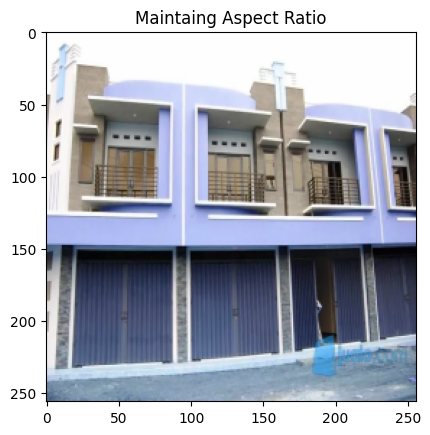

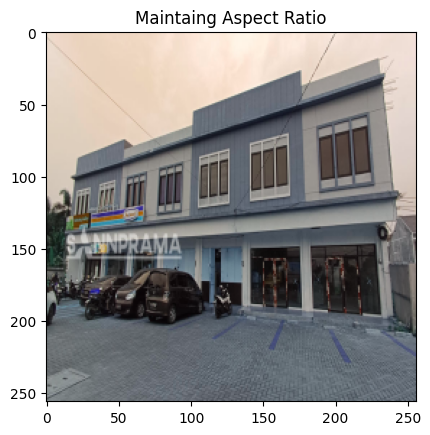

In [3]:
img1 = cv2.imread("ruko-01.jpg")
img2 = cv2.imread("ruko-02.jpg",cv2.IMREAD_COLOR)

#Step 1 : Resize Image to 800x600 size 

width = 256
height = width
dim = (width,height)

resize_dim1 = cv2.resize(img1,dsize=dim,interpolation=cv2.INTER_AREA)
resize_dim2 = cv2.resize(img2,dsize=dim,interpolation=cv2.INTER_AREA)

plt.imshow(resize_dim1,cmap="gray");plt.title("Maintaing Aspect Ratio");plt.show()
plt.imshow(resize_dim2,cmap="gray");plt.title("Maintaing Aspect Ratio");plt.show()


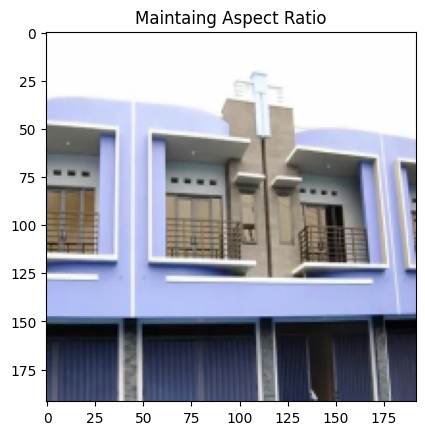

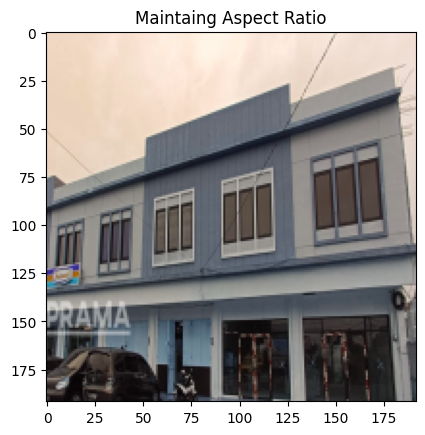

In [4]:
resize_cropped_dim1 = resize_dim1[0:192,50:242]
resize_cropped_dim2 = resize_dim2[0:192,50:242]

plt.imshow(resize_cropped_dim1,cmap="gray");plt.title("Maintaing Aspect Ratio");plt.show()
plt.imshow(resize_cropped_dim2,cmap="gray");plt.title("Maintaing Aspect Ratio");plt.show()

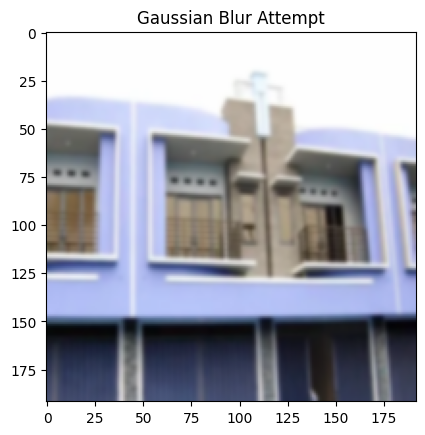

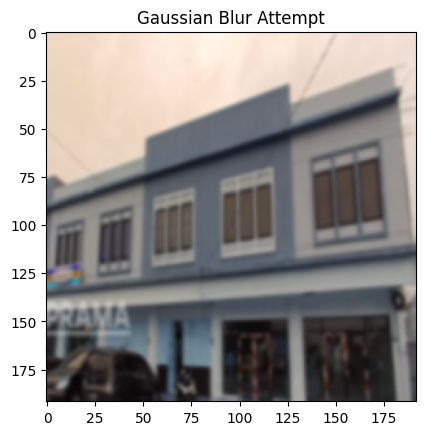

In [5]:
#Step 2 : Gaussian Blur to hide details 

blurred1 = cv2.GaussianBlur(src=resize_cropped_dim1, ksize=(5, 5), sigmaX=1) 
blurred2 = cv2.GaussianBlur(src=resize_cropped_dim2, ksize=(5, 5), sigmaX=1 )

plt.imshow(blurred1,cmap="gray");plt.title("Gaussian Blur Attempt");plt.show()
plt.imshow(blurred2,cmap="gray");plt.title("Gaussian Blur Attempt");plt.show()


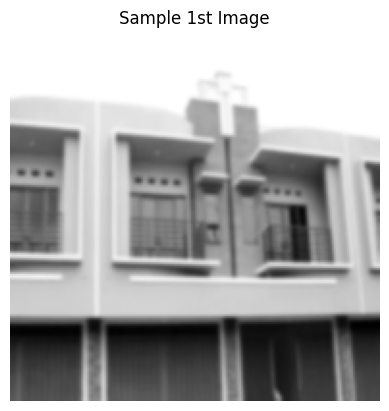

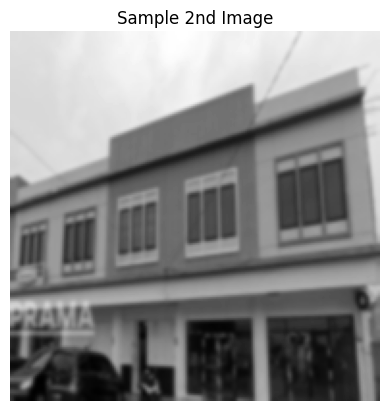

In [6]:
img_rgb1 = cv2.cvtColor(blurred1,cv2.COLOR_BGR2GRAY)
img_rgb2 = cv2.cvtColor(blurred2,cv2.COLOR_BGR2GRAY)

plt.axis("off");plt.imshow(img_rgb1,cmap="gray");plt.title("Sample 1st Image");plt.show()
plt.axis("off");plt.imshow(img_rgb2,cmap="gray");plt.title("Sample 2nd Image")
plt.show()

79
158


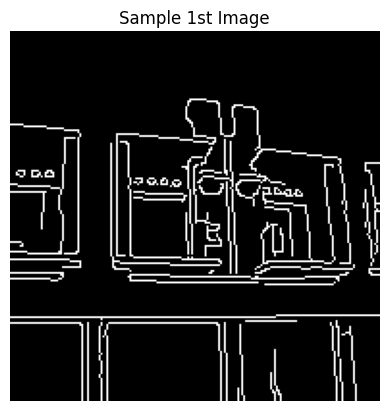

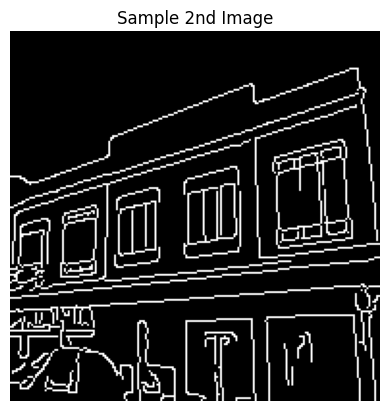

In [7]:
#Step 3 : Apply Canny Function to Find Edges

v = np.median(blurred2)
sigma = 0.33
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
aperture_size = 3

img_edge_l2_1 = cv2.Canny(blurred1,lower,upper,apertureSize=aperture_size,L2gradient=True)
img_edge_l2_2 = cv2.Canny(blurred2,lower,upper,apertureSize=aperture_size,L2gradient=True)
print(lower)
print(upper)
plt.axis("off");plt.imshow(img_edge_l2_1,cmap="gray");plt.title("Sample 1st Image");plt.show()
plt.axis("off");plt.imshow(img_edge_l2_2,cmap="gray");plt.title("Sample 2nd Image")
plt.show()

#Use cv2 to make it grayscale
# cv2.imshow("Canny Edge",img_edge_l2_2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

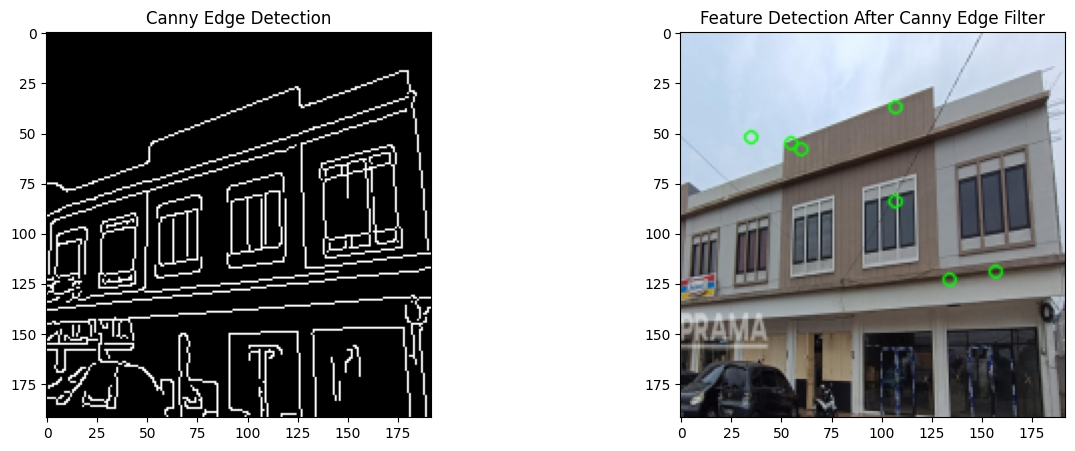

In [8]:
orb = cv2.ORB_create()
# Mask the original image with the Canny edges
keypoints1, descriptors1 = orb.detectAndCompute(img_rgb1, mask=img_edge_l2_1)
keypoints2, descriptors2 = orb.detectAndCompute(img_rgb2, mask=img_edge_l2_2)

# Draw the keypoints on the original image
image1_display = cv2.drawKeypoints(resize_cropped_dim1, keypoints1, None, color=(255, 0, 0), flags=0)
image2_display = cv2.drawKeypoints(resize_cropped_dim2, keypoints1, None, color=(0, 255, 0), flags=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Canny Edge Detection")
plt.imshow(img_edge_l2_2, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Feature Detection After Canny Edge Filter")
plt.imshow(cv2.cvtColor(image2_display, cv2.COLOR_BGR2RGB))
plt.show()

In [34]:
lines = cv2.HoughLinesP(img_edge_l2_2, 1, np.pi/180,70,minLineLength=20,maxLineGap=5)
#Create black empty canvas
line_image = np.zeros_like(resize_cropped_dim1) 
# Draw lines on the image
for line in lines:
   x1, y1, x2, y2 = line[0]
   cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 1,cv2.LINE_AA)
# Show result
print("Line Detection using Hough Transform")
cv2.imshow('lanes',line_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Line Detection using Hough Transform


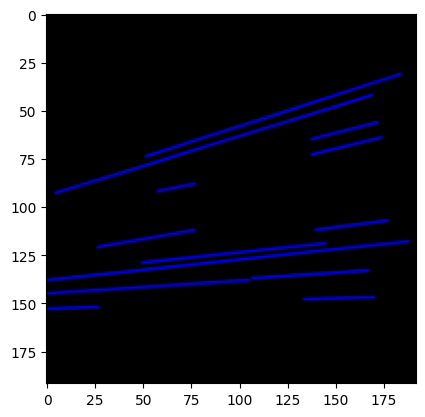

In [35]:
plt.imshow(line_image)

## Test over Loop

### Define Functions for Preprocessing Images and Data

In [3]:
#Make a single function to make the whole processing into one
#THIS CELL CONSISTS OF RESIZING, PREPROCESS IMAGE TO HOUGH LINE PRODUCTION

def resize_image(file,image_width):
    img = cv2.imread(file,cv2.IMREAD_COLOR)
    #Rescale to inputted size 
    width = image_width
    height = image_width
    dim = (width,height)
    resize_image = cv2.resize(img,dsize=dim,interpolation=cv2.INTER_AREA)
    #Crop the resized image the get the area of interest
    x1 = 0
    x2 = int(image_width*0.75)
    y1 = 50
    y2 = int(image_width-(y1*0.2))
    resize_cropped = resize_image[x1:x2,y1:y2]
    output_image = resize_cropped.copy()
    return output_image

def preprocess_image(image):
    #Apply Gaussian Blur
    blurred = cv2.GaussianBlur(src=image, ksize=(5, 5), sigmaX=1) 

    #Convert image to grayscale colour
    gray = cv2.cvtColor(blurred,cv2.COLOR_BGR2GRAY)

    # Enchance Contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    enchanced_gray = clahe.apply(gray)

    #Apply Canny Edge Detection
    v = np.median(blurred)
    sigma = 0.33
    lower = int(max(50, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    aperture_size = 3
    img_edge = cv2.Canny(enchanced_gray,lower,upper,apertureSize=aperture_size,L2gradient=True)
    return img_edge


def hough_line_comparison(canny, original):
    lines = cv2.HoughLinesP(canny,1, np.pi/180,40,minLineLength=60,maxLineGap=10)
    #Create black empty canvas
    line_image = np.zeros_like(original) 
    # Draw lines on the image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            #Apply hough lines into black empty canvas with white color lines
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 255, 255), 1,cv2.LINE_AA)
    return line_image


In [4]:
#CONVERT HEIC FORMAT IMAGE TO JPG
def heic_tp_jpg(img_path):
    register_heif_opener()
    heic_image = Image.open(img_path)
    # Convert to a format compatible with OpenCV (e.g., RGB)
    heic_image.convert('RGB').save(img_path+'.jpg')


In [5]:
#Preprocess Features and Target Variables

def normalize_feature(feature):
    #Normalize pixels of array image
    X_array = (np.array(feature)/255.0)
    return X_array

def normalize_labels(target):
    #Use Encoder to turn labels into integers values
    label_encode = LabelEncoder()
    y_label = label_encode.fit_transform(target)
    return y_label


### Start Preprocess Image and DataFrame

In [6]:
import os
directory = ("real_dataset/")
new_directory = "preprocess"

images = []
labels = []

valid_folder = ["Apartment","Penthouse","Ruko","Rumah 1 lantai"]
for class_dir in os.listdir(directory):
    #Verify if subfolder name is included in valid_folder list
    if class_dir in valid_folder:
        class_path = os.path.join(directory, class_dir)
        #Class_path value is "real-dataset/BuildingType"

        #Verify if class_path is a directory and not empty
        if os.path.isdir(class_path) and os.listdir(class_path):
            for idx,img_name in enumerate(os.listdir(class_path)):
                img_path = os.path.join(class_path, img_name) #Format : real_dataset/building-type/file name
                #Convert to JPG File becuase HEIC cannot be processed immediately
                if img_path.endswith(".HEIC"):
                    heic_tp_jpg(img_path)

                # #Preprocess Image until Image is given Hough Line
                resized_images = resize_image(img_path,256)
                canny_image = preprocess_image(resized_images)
                hough_image = hough_line_comparison(canny_image,resized_images)

                #Save Preproccsed Image to new directory
                filename = f"{class_dir}-{idx+1}.png"
                new_folder = f"{new_directory}/{class_dir}"
                os.makedirs(new_folder, exist_ok=True)
                new_path = os.path.join(new_folder, filename)
                cv2.imwrite(new_path, hough_image)


#### Start Splliting Dataset

In [6]:
path = os.path.join("preprocess/")
print(os.path.exists(path)) 


True


In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(path,
                                                              image_size=(256, 256),
                                                              validation_split=0.2,
                                                              subset ="training",
                                                              seed=0,
                                                              batch_size=32,
                                                              shuffle=True)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(path,
                                                              image_size=(256, 256),
                                                              validation_split=0.25,
                                                              subset ="validation",
                                                              seed=0,
                                                              batch_size=32,
                                                              shuffle=True)

Found 1201 files belonging to 4 classes.
Using 961 files for training.
Found 1201 files belonging to 4 classes.
Using 300 files for validation.


In [8]:
class_name = train_ds.class_names
print(class_name)

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['Apartment', 'Penthouse', 'Ruko', 'Rumah 1 lantai']
(32, 256, 256, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(250).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

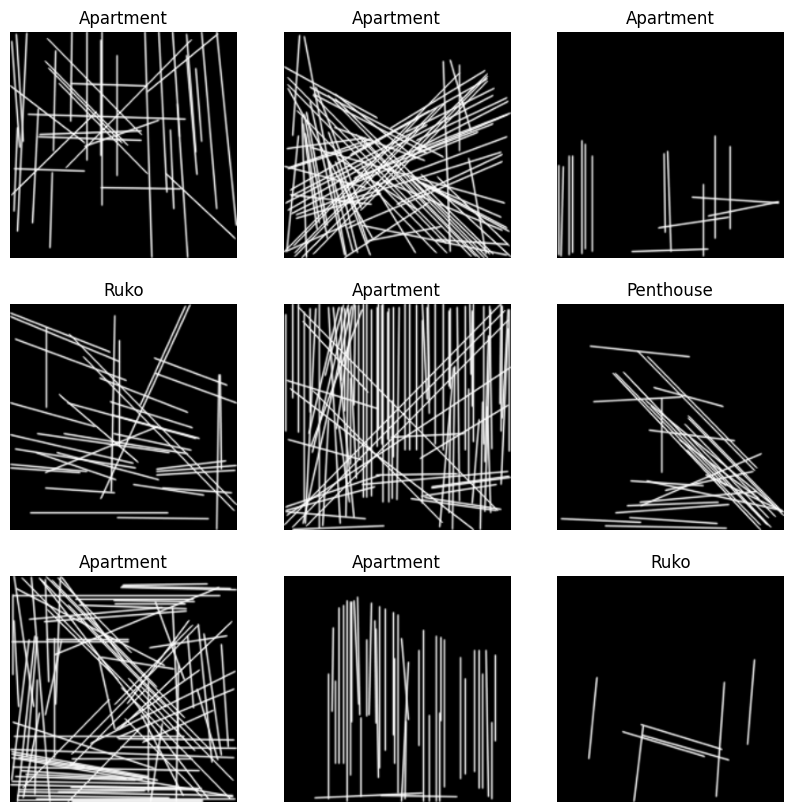

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_name[labels[i]])
    plt.axis("off")

In [11]:
normalization_layer = Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


### Define ANN Model with Keras Module

In [12]:
num_classes = len(class_name)
model = Sequential([
        Rescaling(1./255, input_shape=(256, 256, 3)),
        Flatten(),
        Dense(128,activation="relu"),
        Dense(64,activation="relu"),
        Dropout(0.2),

        Dense(32,activation='relu'),
        Dense(16,activation='relu'),
        Dropout(0.2),
        BatchNormalization(),

        Dense(num_classes,activation="softmax"),
    ])
    
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
    
summary = model.summary()



c:\Users\viola\anaconda3\envs\opencv-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,176,948 (96.04 MB)

 Trainable params: 25,176,916 (96.04 MB)

 Non-trainable params: 32 (128.00 B)

In [13]:
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)

epochs=50
history = model.fit(
  train_ds,
  validation_data = valid_ds,
  epochs=epochs,
  verbose=2,
  callbacks = [tensorboard_callback]
)

Epoch 1/50


c:\Users\viola\anaconda3\envs\opencv-env\Lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


31/31 - 5s - 173ms/step - accuracy: 0.2893 - loss: 1.5283 - val_accuracy: 0.7467 - val_loss: 0.9615
Epoch 2/50
31/31 - 3s - 97ms/step - accuracy: 0.4246 - loss: 1.2808 - val_accuracy: 0.8200 - val_loss: 0.7578
Epoch 3/50
31/31 - 3s - 84ms/step - accuracy: 0.5806 - loss: 1.1474 - val_accuracy: 0.8267 - val_loss: 0.7217
Epoch 4/50
31/31 - 2s - 68ms/step - accuracy: 0.6961 - loss: 1.0363 - val_accuracy: 0.8233 - val_loss: 0.6625
Epoch 5/50
31/31 - 2s - 67ms/step - accuracy: 0.7898 - loss: 0.8587 - val_accuracy: 0.8233 - val_loss: 0.6398
Epoch 6/50
31/31 - 2s - 68ms/step - accuracy: 0.8117 - loss: 0.7541 - val_accuracy: 0.8233 - val_loss: 0.5913
Epoch 7/50
31/31 - 2s - 68ms/step - accuracy: 0.8169 - loss: 0.6915 - val_accuracy: 0.8233 - val_loss: 0.5582
Epoch 8/50
31/31 - 2s - 69ms/step - accuracy: 0.8179 - loss: 0.6380 - val_accuracy: 0.8233 - val_loss: 0.5482
Epoch 9/50
31/31 - 2s - 68ms/step - accuracy: 0.8221 - loss: 0.5733 - val_accuracy: 0.8233 - val_loss: 0.5114
Epoch 10/50
31/31 - 

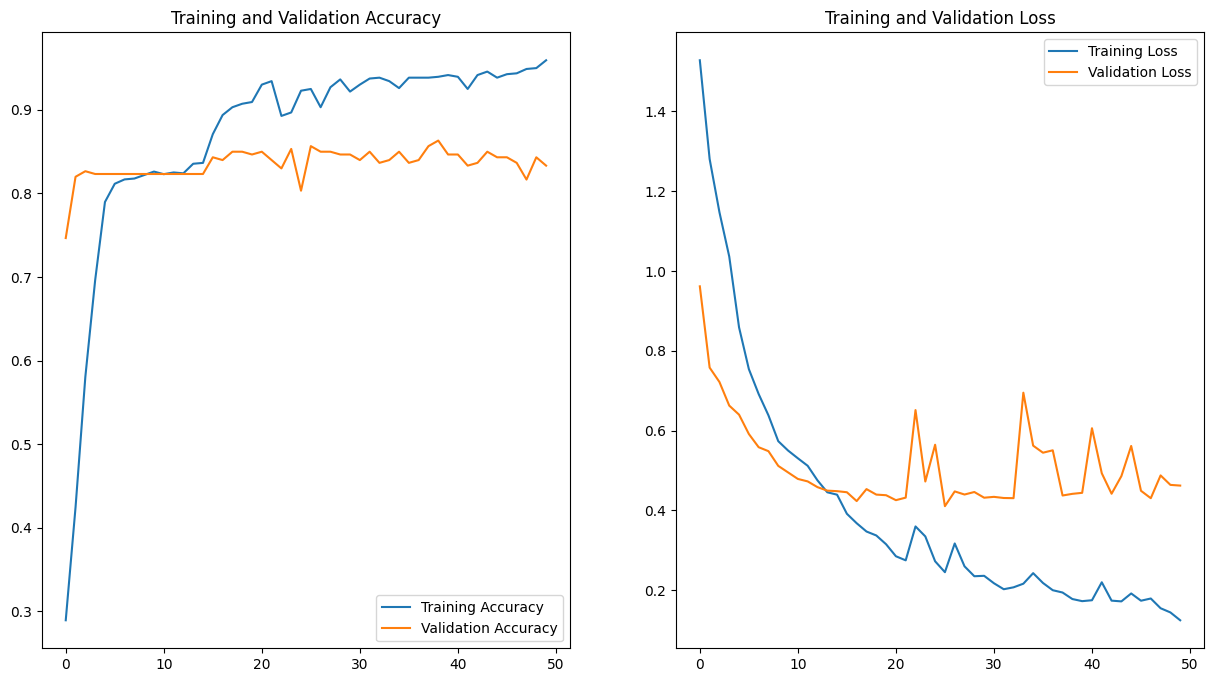

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# Evaluate model on the test set
test_metrics = model.evaluate(valid_ds)
print(f"Test Loss: {test_metrics[0]}, Test Accuracy: {test_metrics[1]}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8650 - loss: 0.3846
Test Loss: 0.461952269077301, Test Accuracy: 0.8333333134651184


In [16]:
print(os.getcwd())


e:\projectDL


In [17]:
test_path = os.path.join("ruko-01.jpg")
print(os.path.exists(test_path)) 


True


In [18]:
img = tf.keras.utils.load_img(
    test_path, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_name[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
This image most likely belongs to Apartment with a 47.54 percent confidence.


In [19]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

IMG_SIZE = (256, 256) 

test_image = "apartment-01.jpg"
# Load and preprocess the image
img = load_img(test_image, target_size=IMG_SIZE)
img_array = img_to_array(img) / 255.0  # Normalize if your model requires it
img_array = np.expand_dims(img_array, axis=0)

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])  # Assuming a classification task

# Customize based on your class labels
class_labels = ['Class A', 'Class B', 'Class C',"Class D"]  # Replace with your actual classes
result = {
            'predicted_class': class_labels[predicted_class],
            'confidence': (predictions[0][predicted_class])
}

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
{'predicted_class': 'Class C', 'confidence': np.float32(0.5620629)}


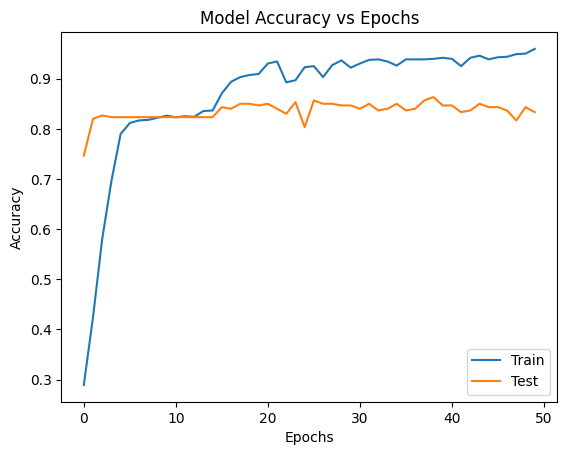

In [20]:
#Visualization Accuracy 
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

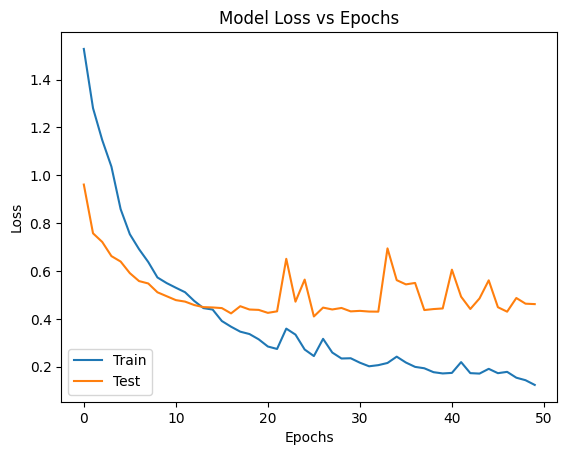

In [21]:
#Visualization Loss 
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Test'], loc='lower left')
plt.show()

In [22]:
from tensorflow.keras.models import load_model

#Save model for deployment

model.save("ann_model.h5")

### Define ANN Model Without Keras Module

In [12]:
def relu(x): 
  return np.maximum(0,x)

def relu_derivative(x): #Derivative of ReLU activation
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # To prevent overflow
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def categorical_crossentropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

In [13]:
#Reuse the variables 
print(X_images.shape) #Flattened Array (note the array has been normalized its pixels)
print(label_onehot.shape) #One Hot encoded consisted of 4 columns

(224, 110592)
(224, 4)


In [24]:
#ANN Structure
input_size = X_images.shape[1]  #Equivalent of input_shape example (150528,)
hidden_size = 192 #Number of neurons in hidden layer
output_size = y.shape[1] #Desired output (4 classes)

#Initialize Random weights and bias
w_hidden = np.random.randn(input_size,hidden_size) 
w_output = np.random.randn(hidden_size,output_size)

learning_rate = 0.001


In [25]:
epochs = 80
error_history= []

for i in range(epochs):
#Forward pass through hidden layer
  z1 = np.dot(X_images,w_hidden)
  a1 = relu(z1)

  #Forward pass through output layer
  z2 = np.dot(a1, w_output)
  a2 = softmax(z2)
  #Make equivalent that hidden_input = z1, hidden_output = a1
  #final_input = z2, final_output = a2

  #Count Loss with Categorical Crossentropy (multi class classification)
  loss = categorical_crossentropy(label_onehot, a2)
  error_history.append(loss)

  #Backpropagation
  delta_a2 = a2 - label_onehot #delta_a2 = a2 - Y
  delta_z2 = delta_a2 * a2 * (1-a2)

  # Compute gradients for the hidden layer
  delta_a1 = np.dot(delta_z2, w_output.T) 
  delta_z1 = delta_a1 * relu_derivative(z1)  # Derivative of ReLU

  #Define derivative weights
  d_w_output = np.dot(a1.T, delta_z2)  / label_onehot.size
  d_w_hidden = np.dot(X_images.T, delta_z1) / label_onehot.size

  # Update weights using gradient descent
  w_hidden -= learning_rate * d_w_hidden
  w_output -= learning_rate * d_w_output

  if (i + 1) % 10 == 0:
        print(f'Epoch: {i + 1}, Loss: {loss}')
        
print(f"Final loss history: {error_history[0]:.4f}")



Epoch: 10, Loss: 23.724693118630732
Epoch: 20, Loss: 23.723487657685194
Epoch: 30, Loss: 23.722298976234185
Epoch: 40, Loss: 23.72116199712328
Epoch: 50, Loss: 23.720066554474215
Epoch: 60, Loss: 23.718996597256712
Epoch: 70, Loss: 23.717940741688274
Epoch: 80, Loss: 23.716892200465686
Final loss history: 23.7257


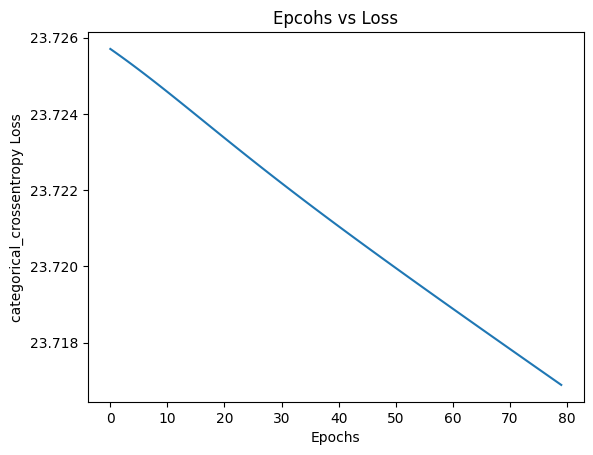

In [26]:
plt.plot(error_history)
plt.xlabel("Epochs")
plt.ylabel("categorical_crossentropy Loss")
plt.title("Epcohs vs Loss")
plt.show()